In [ ]:
# Work in progress of an AI to predict outcomes of formula 1 races
# Trying to predict which driver has the highest likehood of winning a race
# Considering: driver standing, team standing, course, experience, weather etc.
# Data scraping based on an article I found on medium

In [1]:
# ---------------- IMPORTS
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import requests
from matplotlib import pyplot as plt
import bs4
from bs4 import BeautifulSoup

from selenium import webdriver
from dateutil.relativedelta import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
# ---------------- CONFIG
startYear = 1985
endYear = 2021
testYear = 2020
loadfinal = True
EPOCHS = 120
oversamplerate = 0.4

In [3]:
# ---------------- RACES
races = {'season': [],
        'round': [],
        'circuit_id': [],
        'lat': [],
        'long': [],
        'country': [],
        'date': [],
        'url': []}

for year in list(range(startYear, endYear + 1)):
    
    url = 'https://ergast.com/api/f1/{}.json'
    r = requests.get(url.format(year))
    json = r.json()

    for item in json['MRData']['RaceTable']['Races']:
        try:
            races['season'].append(int(item['season']))
        except:
            races['season'].append(None)

        try:
            races['round'].append(int(item['round']))
        except:
            races['round'].append(None)

        try:
            races['circuit_id'].append(item['Circuit']['circuitId'])
        except:
            races['circuit_id'].append(None)

        try:
            races['lat'].append(float(item['Circuit']['Location']['lat']))
        except:
            races['lat'].append(None)

        try:
            races['long'].append(float(item['Circuit']['Location']['long']))
        except:
            races['long'].append(None)

        try:
            races['country'].append(item['Circuit']['Location']['country'])
        except:
            races['country'].append(None)

        try:
            races['date'].append(item['date'])
        except:
            races['date'].append(None)

        try:
            races['url'].append(item['url'])
        except:
            races['url'].append(None)
        
races = pd.DataFrame(races)
races.head()

,season,round,circuit_id,lat,long,country,date,url
0,1985,1,jacarepagua,-22.9756,-43.39500,Brazil,1985-04-07,http://en.wikipedia.org/wiki/1985_Brazilian_Gr...
1,1985,2,estoril,38.7506,-9.39417,Portugal,1985-04-21,http://en.wikipedia.org/wiki/1985_Portuguese_G...
2,1985,3,imola,44.3439,11.71670,Italy,1985-05-05,http://en.wikipedia.org/wiki/1985_San_Marino_G...
3,1985,4,monaco,43.7347,7.42056,Monaco,1985-05-19,http://en.wikipedia.org/wiki/1985_Monaco_Grand...
4,1985,5,villeneuve,45.5000,-73.52280,Canada,1985-06-16,http://en.wikipedia.org/wiki/1985_Canadian_Gra...


In [4]:
# ---------------- ROUNDS
rounds = []
for year in np.array(races.season.unique()):
    rounds.append([year, list(races[races.season == year]['round'])])

# query API
    
results = {'season': [],
          'round':[],
           'circuit_id':[],
          'driver': [],
           'date_of_birth': [],
           'nationality': [],
          'constructor': [],
          'grid': [],
          'time': [],
          'status': [],
          'points': [],
          'podium': []}

for n in list(range(len(rounds))):
    for i in rounds[n][1]:
    
        url = 'http://ergast.com/api/f1/{}/{}/results.json'
        r = requests.get(url.format(rounds[n][0], i))
        json = r.json()

        if json['MRData']['RaceTable']['Races'] == []:
            continue
            
        for item in json['MRData']['RaceTable']['Races'][0]['Results']:
            try:
                results['season'].append(int(json['MRData']['RaceTable']['Races'][0]['season']))
            except:
                results['season'].append(None)

            try:
                results['round'].append(int(json['MRData']['RaceTable']['Races'][0]['round']))
            except:
                results['round'].append(None)

            try:
                results['circuit_id'].append(json['MRData']['RaceTable']['Races'][0]['Circuit']['circuitId'])
            except:
                results['circuit_id'].append(None)

            try:
                results['driver'].append(item['Driver']['driverId'])
            except:
                results['driver'].append(None)
            
            try:
                results['date_of_birth'].append(item['Driver']['dateOfBirth'])
            except:
                results['date_of_birth'].append(None)
                
            try:
                results['nationality'].append(item['Driver']['nationality'])
            except:
                results['nationality'].append(None)

            try:
                results['constructor'].append(item['Constructor']['constructorId'])
            except:
                results['constructor'].append(None)

            try:
                results['grid'].append(int(item['grid']))
            except:
                results['grid'].append(None)

            try:
                results['time'].append(int(item['Time']['millis']))
            except:
                results['time'].append(None)

            try:
                results['status'].append(item['status'])
            except:
                results['status'].append(None)

            try:
                results['points'].append(int(item['points']))
            except:
                results['points'].append(None)

            try:
                results['podium'].append(int(item['position']))
            except:
                results['podium'].append(None)

results = pd.DataFrame(results)
results.head()

,season,round,circuit_id,driver,date_of_birth,nationality,constructor,grid,time,status,points,podium
0,1985,1,jacarepagua,prost,1955-02-24,French,mclaren,6,6086115.0,Finished,9.0,1
1,1985,1,jacarepagua,alboreto,1956-12-23,Italian,ferrari,1,6089374.0,Finished,6.0,2
2,1985,1,jacarepagua,angelis,1958-03-26,Italian,team_lotus,3,NaN,+1 Lap,4.0,3
3,1985,1,jacarepagua,arnoux,1948-07-04,French,ferrari,7,NaN,+2 Laps,3.0,4
4,1985,1,jacarepagua,tambay,1949-06-25,French,renault,11,NaN,+2 Laps,2.0,5


In [5]:
# ---------------- DRIVER
driver_standings = {'season': [],
                    'round':[],
                    'driver': [],
                    'driver_points': [],
                    'driver_wins': [],
                   'driver_standings_pos': []}

# query API
for n in list(range(len(rounds))):     
    for i in rounds[n][1]:    # iterate through rounds of each year
        url = 'https://ergast.com/api/f1/{}/{}/driverStandings.json'
        r = requests.get(url.format(rounds[n][0], i))
        json = r.json()
        if json['MRData']['StandingsTable']['StandingsLists'] == []:
            continue
        for item in json['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']:
            try:
                driver_standings['season'].append(int(json['MRData']['StandingsTable']['StandingsLists'][0]['season']))
            except:
                driver_standings['season'].append(None)

            try:
                driver_standings['round'].append(int(json['MRData']['StandingsTable']['StandingsLists'][0]['round']))
            except:
                driver_standings['round'].append(None)
                                         
            try:
                driver_standings['driver'].append(item['Driver']['driverId'])
            except:
                driver_standings['driver'].append(None)
            
            try:
                driver_standings['driver_points'].append(int(item['points']))
            except:
                driver_standings['driver_points'].append(None)
            
            try:
                driver_standings['driver_wins'].append(int(item['wins']))
            except:
                driver_standings['driver_wins'].append(None)
                
            try:
                driver_standings['driver_standings_pos'].append(int(item['position']))
            except:
                driver_standings['driver_standings_pos'].append(None)
driver_standings = pd.DataFrame(driver_standings)

# define lookup function to shift points and number of wins from previous rounds
def lookup (df, team, points):
    df['lookup1'] = df.season.astype(str) + df[team] + df['round'].astype(str)
    df['lookup2'] = df.season.astype(str) + df[team] + (df['round']-1).astype(str)
    new_df = df.merge(df[['lookup1', points]], how = 'left', left_on='lookup2',right_on='lookup1')
    new_df.drop(['lookup1_x', 'lookup2', 'lookup1_y'], axis = 1, inplace = True)
    new_df.rename(columns = {points+'_x': points+'_after_race', points+'_y': points}, inplace = True)
    new_df[points].fillna(0, inplace = True)
    return new_df
  
driver_standings = lookup(driver_standings, 'driver', 'driver_points')
driver_standings = lookup(driver_standings, 'driver', 'driver_wins')
driver_standings = lookup(driver_standings, 'driver', 'driver_standings_pos')
driver_standings.drop(['driver_points_after_race', 'driver_wins_after_race', 'driver_standings_pos_after_race'], 
                      axis = 1, inplace = True)
driver_standings.head()

,season,round,driver,driver_points,driver_wins,driver_standings_pos
0,1985,1,prost,0.0,0.0,0.0
1,1985,1,alboreto,0.0,0.0,0.0
2,1985,1,angelis,0.0,0.0,0.0
3,1985,1,arnoux,0.0,0.0,0.0
4,1985,1,tambay,0.0,0.0,0.0


In [6]:
# ---------------- CONSTRUCTOR
constructor_rounds = rounds#[8:]
constructor_standings = {'season': [],
                    'round':[],
                    'constructor': [],
                    'constructor_points': [],
                    'constructor_wins': [],
                   'constructor_standings_pos': []}

# query API
for n in list(range(len(constructor_rounds))):
    for i in constructor_rounds[n][1]:
        url = 'https://ergast.com/api/f1/{}/{}/constructorStandings.json'
        r = requests.get(url.format(constructor_rounds[n][0], i))
        json = r.json()
        for item in json['MRData']['StandingsTable']['StandingsLists'][0]['ConstructorStandings']:
            try:
                constructor_standings['season'].append(int(json['MRData']['StandingsTable']['StandingsLists'][0]['season']))
            except:
                constructor_standings['season'].append(None)

            try:
                constructor_standings['round'].append(int(json['MRData']['StandingsTable']['StandingsLists'][0]['round']))
            except:
                constructor_standings['round'].append(None)
                                         
            try:
                constructor_standings['constructor'].append(item['Constructor']['constructorId'])
            except:
                constructor_standings['constructor'].append(None)
            
            try:
                constructor_standings['constructor_points'].append(int(item['points']))
            except:
                constructor_standings['constructor_points'].append(None)
            
            try:
                constructor_standings['constructor_wins'].append(int(item['wins']))
            except:
                constructor_standings['constructor_wins'].append(None)
                
            try:
                constructor_standings['constructor_standings_pos'].append(int(item['position']))
            except:
                constructor_standings['constructor_standings_pos'].append(None)
            
constructor_standings = pd.DataFrame(constructor_standings)
constructor_standings = lookup(constructor_standings, 'constructor', 'constructor_points')
constructor_standings = lookup(constructor_standings, 'constructor', 'constructor_wins')
constructor_standings = lookup(constructor_standings, 'constructor', 'constructor_standings_pos')
constructor_standings.drop(['constructor_points_after_race', 'constructor_wins_after_race','constructor_standings_pos_after_race' ],
                           axis = 1, inplace = True)
constructor_standings.head()

,season,round,constructor,constructor_points,constructor_wins,constructor_standings_pos
0,1985,1,mclaren,0.0,0.0,0.0
1,1985,1,ferrari,0.0,0.0,0.0
2,1985,1,team_lotus,0.0,0.0,0.0
3,1985,1,renault,0.0,0.0,0.0
4,1985,1,ligier,0.0,0.0,0.0


In [7]:
# ---------------- QUALIFYING
qualifying_results = pd.DataFrame()

# Qualifying times are only available from 1983
for year in list(range(startYear, endYear + 1)):
    url = 'https://www.formula1.com/en/results.html/{}/races.html'
    r = requests.get(url.format(year))
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # find links to all circuits for a certain year
    year_links = []
    for page in soup.find_all('a', attrs = {'class':"resultsarchive-filter-item-link FilterTrigger"}):
        link = page.get('href')
        if f'/en/results.html/{year}/races/' in link: 
            year_links.append(link)
    
    # for each circuit, switch to the starting grid page and read table
    year_df = pd.DataFrame()
    new_url = 'https://www.formula1.com{}'
    for n, link in list(enumerate(year_links)):
        link = link.replace('race-result.html', 'starting-grid.html')
        df = pd.read_html(new_url.format(link))
        df = df[0]
        df['season'] = year
        df['round'] = n+1
        for col in df:
            if 'Unnamed' in col:
                df.drop(col, axis = 1, inplace = True)
        year_df = pd.concat([year_df, df])

    # concatenate all tables from all years  
    qualifying_results = pd.concat([qualifying_results, year_df])

# rename columns
qualifying_results.rename(columns = {'Pos': 'grid', 'Driver': 'driver_name', 'Car': 'car',
                                     'Time': 'qualifying_time'}, inplace = True)
# drop driver number column
qualifying_results.drop('No', axis = 1, inplace = True)
qualifying_results.head()

,grid,driver_name,car,qualifying_time,season,round
0,1,Michele Alboreto ALB,Ferrari,1:27.768,1985,1
1,2,Keke Rosberg ROS,Williams Honda,1:27.864,1985,1
2,3,Elio de Angelis DEA,Lotus Renault,1:28.081,1985,1
3,4,Ayrton Senna SEN,Lotus Renault,1:28.389,1985,1
4,5,Nigel Mansell MAN,Williams Honda,1:28.848,1985,1


In [8]:
# ---------------- WEATHER
weather = races.iloc[:,[0,1,2]]
info = []
# read wikipedia tables
for link in races.url:
    try:
        df = pd.read_html(link)[0]
        if 'Weather' in list(df.iloc[:,0]):
            n = list(df.iloc[:,0]).index('Weather')
            info.append(df.iloc[n,1])
        else:
            df = pd.read_html(link)[1]
            if 'Weather' in list(df.iloc[:,0]):
                n = list(df.iloc[:,0]).index('Weather')
                info.append(df.iloc[n,1])
            else:
                df = pd.read_html(link)[2]
                if 'Weather' in list(df.iloc[:,0]):
                    n = list(df.iloc[:,0]).index('Weather')
                    info.append(df.iloc[n,1])
                else:
                    df = pd.read_html(link)[3]
                    if 'Weather' in list(df.iloc[:,0]):
                        n = list(df.iloc[:,0]).index('Weather')
                        info.append(df.iloc[n,1])
                    else:
                        driver = webdriver.Chrome()
                        driver.get(link)

                        # click language button
                        button = driver.find_element_by_link_text('Italiano')
                        button.click()
                        
                        # find weather in italian with selenium
                        clima = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr[9]/td').text
                        info.append(clima)           
    except:
        info.append('not found')
# append column with weather information to dataframe  
weather['weather'] = info
# set up a dictionary to convert weather information into keywords
weather_dict = {'weather_warm': ['soleggiato', 'clear', 'warm', 'hot', 'sunny', 'fine', 'mild', 'sereno'],
               'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
               'weather_dry': ['dry', 'asciutto'],
               'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorms', 'rainy'],
               'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto']}
# map new df according to weather dictionary
weather_df = pd.DataFrame(columns = weather_dict.keys())
for col in weather_df:
    weather_df[col] = weather['weather'].map(lambda x: 1 if any(i in weather_dict[col] for i in x.lower().split()) else 0)

weather_info = pd.concat([weather, weather_df], axis = 1)
weather_info.head()

<ipython-input-8-8ce695d7a713>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['weather'] = info


,season,round,circuit_id,weather,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
0,1985,1,jacarepagua,"Dry, 34 °C (93 °F) air temperature",0,0,0,0,0
1,1985,2,estoril,"Overcast, Cold, Rain",0,0,0,1,0
2,1985,3,imola,not found,0,0,0,0,0
3,1985,4,monaco,Dry,0,0,1,0,0
4,1985,5,villeneuve,Sunny with temperatures approaching 20.5 °C (6...,1,0,0,0,0


In [9]:
# ---------------- MERGE DATAFRAMES
df1 = pd.merge(races, weather_info, how='inner', 
               on=['season', 'round', 'circuit_id']).drop(['lat', 'long','country','weather'], axis = 1)
df2 = pd.merge(df1, results, how='inner', 
               on=['season', 'round', 'circuit_id']).drop(['url','points', 'status', 'time'], axis = 1)
df3 = pd.merge(df2, driver_standings, how='left', 
               on=['season', 'round', 'driver']) 
df4 = pd.merge(df3, constructor_standings, how='left', 
               on=['season', 'round', 'constructor']) #from 1958
final_df = pd.merge(df4, qualifying_results, how='inner', 
                    on=['season', 'round', 'grid']).drop(['driver_name', 'car'], axis = 1) #from 1983

In [10]:
# ---------------- SAVE TABLES TO CSV
weather_info.to_csv("weather_info.csv")
qualifying_results.to_csv("qualy.csv")
constructor_standings.to_csv("constructor.csv")
driver_standings.to_csv("driver.csv")
results.to_csv("result.csv")
races.to_csv("races.csv")
final_df.to_csv("final.csv")

In [ ]:
# START HERE

#### Load from Disk

In [15]:
if loadfinal:
    final_df = pd.read_csv("final.csv").drop(columns = "Unnamed: 0")
final_df = final_df.drop(columns = "nationality")
final_df.head(10)

,season,round,circuit_id,date,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,date_of_birth,constructor,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time
0,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,prost,1955-02-24,mclaren,6,1,0.0,0.0,0.0,0.0,0.0,0.0,1:29.117
1,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,alboreto,1956-12-23,ferrari,1,2,0.0,0.0,0.0,0.0,0.0,0.0,1:27.768
2,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,angelis,1958-03-26,team_lotus,3,3,0.0,0.0,0.0,0.0,0.0,0.0,1:28.081
3,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,arnoux,1948-07-04,ferrari,7,4,0.0,0.0,0.0,0.0,0.0,0.0,1:29.612
4,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,tambay,1949-06-25,renault,11,5,0.0,0.0,0.0,0.0,0.0,0.0,1:30.254
5,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,laffite,1943-11-21,ligier,15,6,0.0,0.0,0.0,0.0,0.0,0.0,1:32.021
6,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,johansson,1956-09-08,tyrrell,23,7,0.0,0.0,0.0,0.0,0.0,0.0,1:37.293
7,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,brundle,1959-06-01,tyrrell,21,8,0.0,0.0,0.0,0.0,0.0,0.0,1:36.152
8,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,alliot,1954-07-27,ram,20,9,0.0,0.0,0.0,0.0,0.0,0.0,1:35.726
9,1985,1,jacarepagua,1985-04-07,0,0,0,0,0,warwick,1954-08-27,renault,10,10,0.0,0.0,0.0,0.0,0.0,0.0,1:30.100


In [16]:
# ---------------- FINAL REPLACING OF STUFF
final_df["driver"] = final_df["driver"].replace("verstappen","max_verstappen")
#final_df["constructor"] = final_df["constructor"].replace("alpine","renault")

In [13]:
# ---------------- INSERT FILE TO PREDICT ON HERE / PRODUCTION DATA


In [17]:
# ---------------- PREPARE FINAL DF FOR ML
final_df['date'] = pd.to_datetime(final_df.date)
final_df['date_of_birth'] = pd.to_datetime(final_df.date_of_birth)
final_df['driver_age'] = final_df.apply(lambda x: 
                                        relativedelta(x['date'], x['date_of_birth']).years, axis=1)
final_df.drop(['date', 'date_of_birth'], axis = 1, inplace = True)
# fill/drop nulls
for col in ['driver_points', 'driver_wins', 'driver_standings_pos', 'constructor_points', 
            'constructor_wins' , 'constructor_standings_pos']:
    final_df[col].fillna(0, inplace = True)
    final_df[col] = final_df[col].map(lambda x: int(x))  
final_df.dropna(inplace = True )
# convert to boolean to save space
for col in ['weather_warm', 'weather_cold','weather_dry', 'weather_wet', 'weather_cloudy']:
    final_df[col] = final_df[col].map(lambda x: bool(x))
# calculate difference in qualifying times
final_df['qualifying_time'] = final_df.qualifying_time.map(lambda x: 0 if str(x) == '00.000' 
                             else(float(str(x).split(':')[0]) + 
                                  (60 * float(str(x).split(':')[0])) if x != 0 else 0))
final_df = final_df[final_df['qualifying_time'] != 0]
final_df.sort_values(['season', 'round', 'grid'], inplace = True)
final_df['qualifying_time_diff'] = final_df.groupby(['season', 'round']).qualifying_time.diff()
final_df['qualifying_time'] = final_df.groupby(['season', 
                                                'round']).qualifying_time_diff.cumsum().fillna(0)
final_df.drop('qualifying_time_diff', axis = 1, inplace = True)

# get dummies
final_df["driverBackup"] = final_df["driver"]
df_dum = pd.get_dummies(final_df, columns = ['circuit_id', 'constructor', 'driver'] )
for col in df_dum.columns:
    if 'nationality' in col and df_dum[col].sum() < 140:
        df_dum.drop(col, axis = 1, inplace = True)   
    elif 'constructor' in col and df_dum[col].sum() < 140:
        df_dum.drop(col, axis = 1, inplace = True)
    elif 'circuit_id' in col and df_dum[col].sum() < 70:
        df_dum.drop(col, axis = 1, inplace = True)
    else:
        pass
    
df_dum.tail()

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age,driverBackup,circuit_id_BAK,circuit_id_adelaide,circuit_id_albert_park,circuit_id_americas,circuit_id_bahrain,circuit_id_catalunya,circuit_id_detroit,circuit_id_estoril,circuit_id_galvez,circuit_id_hockenheimring,circuit_id_hungaroring,circuit_id_imola,circuit_id_indianapolis,circuit_id_interlagos,circuit_id_istanbul,circuit_id_jacarepagua,circuit_id_jerez,circuit_id_kyalami,circuit_id_magny_cours,circuit_id_marina_bay,circuit_id_monaco,circuit_id_monza,circuit_id_nurburgring,circuit_id_osterreichring,circuit_id_phoenix,circuit_id_red_bull_ring,circuit_id_ricard,circuit_id_rodriguez,circuit_id_sepang,circuit_id_shanghai,circuit_id_silverstone,circuit_id_sochi,circuit_id_spa,circuit_id_suzuka,circuit_id_valencia,circuit_id_villeneuve,circuit_id_yas_marina,circuit_id_yeongam,constructor_arrows,constructor_bar,constructor_benetton,constructor_brabham,constructor_ferrari,constructor_footwork,constructor_force_india,constructor_haas,constructor_jaguar,constructor_jordan,constructor_larrousse,constructor_ligier,constructor_lotus_f1,constructor_mclaren,constructor_mercedes,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams,driver_acheson,driver_adams,driver_aitken,driver_albers,driver_albon,driver_alboreto,driver_alesi,driver_alguersuari,driver_alliot,driver_alonso,driver_ambrosio,driver_andretti,driver_angelis,driver_apicella,driver_arnoux,driver_badoer,driver_bailey,driver_baldi,driver_barbazza,driver_barilla,driver_barrichello,driver_baumgartner,driver_bellof,driver_belmondo,driver_beretta,driver_berg,driver_berger,driver_bernard,driver_bernoldi,driver_blundell,driver_bottas,driver_boullion,driver_bourdais,driver_boutsen,driver_brabham,driver_brendon_hartley,driver_brundle,driver_bruni,driver_bruno_senna,driver_buemi,driver_burti,driver_button,driver_caffi,driver_campos,driver_capelli,driver_cesaris,driver_chandhok,driver_cheever,driver_chiesa,driver_chilton,driver_comas,driver_coulthard,driver_dalmas,driver_damon_hill,driver_danner,driver_davidson,driver_deletraz,driver_diniz,driver_donnelly,driver_doornbos,driver_dumfries,driver_enge,driver_ericsson,driver_fabi,driver_fabre,driver_firman,driver_fisichella,driver_fittipaldi,driver_foitek,driver_fontana,driver_forini,driver_frentzen,driver_friesacher,driver_gachot,driver_garde,driver_gasly,driver_gene,driver_ghinzani,driver_giovinazzi,driver_glock,driver_gounon,driver_grassi,driver_grosjean,driver_grouillard,driver_gugelmin,driver_gutierrez,driver_hakkinen,driver_hamilton,driver_haryanto,driver_heidfeld,driver_herbert,driver_hesnault,driver_hulkenberg,driver_ide,driver_inoue,driver_irvine,driver_johansson,driver_jolyon_palmer,driver_jones,driver_jules_bianchi,driver_karthikeyan,driver_katayama,driver_keke_rosberg,driver_kevin_magnussen,driver_kiesa,driver_klien,driver_kobayashi,driver_kovalainen,driver_kubica,driver_kvyat,driver_laffite,driver_lagorce,driver_lammers,driver_lamy,driver_larini,driver_larrauri,driver_latifi,driver_lauda,driver_lavaggi,driver_leclerc,driver_lehto,driver_liuzzi,driver_lotterer,driver_magnussen,driver_maldonado,driver_manfred_winkelhock,driver_mansell,driver_markus_winkelhock,driver_marques,driver_martini,driver_massa,driver_matta,driver_max_verstappen,driver_mazepin,driver_mazzacane,driver_mcnish,driver_merhi,driver_michael_schumacher,driver_mick_schumacher,driver_modena,driver_montagny,driver_monteiro,driver_montermini,driver_montoya,driver_morbidelli,driver_moreno,driver_nakajima,driver_nakano,driver_nannini,driver_naspetti,driver_nasr,driver_noda,driver_norris,driver_ocon,driver_palmer,driver_panis,driver_pantano,driver_papis,driver_patrese,driver_perez,driver_petrov,driver_pi

In [82]:
# Map podium
df = df_dum.copy()
df.podium = df.podium.map(lambda x: 1 if x == 1 else 0)

# Validation data
#validationSample = df.sample(round(len(df) * 0.14))
validationSample = df[df["season"] > testYear]

df = df.drop(validationSample.index)
driver_val = validationSample["driverBackup"]
X_val = validationSample.drop(['podium', "driverBackup"], axis = 1)
y_val = validationSample.podium

# Shuffle data
df = df.sample(frac = 1).reset_index(drop = True)

# Train data
X = df.drop(['podium', "driverBackup"], axis = 1)
y = df.podium

# Ovresample imbalanced dataset
from imblearn.over_sampling import SMOTE
oversample = True
if oversample == True:
    oversample = SMOTE(sampling_strategy = 0.32)
    X, y = oversample.fit_resample(X, y)

# Train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Scale
Xscaler = StandardScaler()
X_train = Xscaler.fit_transform(X)
y_train = y.to_numpy()
#X_test = Xscaler.transform(X_test)

print(len(X_train), len(y_train), len(validationSample))

17422 17422 357


In [113]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(180, activation='linear'),
    tf.keras.layers.Dense(400, activation='relu'),
   # tf.keras.layers.Dropout(0.02),
    tf.keras.layers.Dense(400, activation='relu'),
 #   tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(240, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [
                    tf.keras.metrics.BinaryAccuracy(name='binAccur')
              ])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binAccur', factor = 0.4,
                              patience = 0, min_lr = 0.00000001)

model

In [114]:
history = model.fit(X_train, y_train, epochs = 20, verbose = 1, validation_split = 0.2, callbacks = [reduce_lr])

Epoch 1/20
436/436 [==============================] - 3s 8ms/step - loss: 0.1388 - binAccur: 0.9480 - val_loss: 0.6243 - val_binAccur: 0.7948
Epoch 2/20
436/436 [==============================] - 3s 7ms/step - loss: 0.1172 - binAccur: 0.9533 - val_loss: 0.5520 - val_binAccur: 0.6867
Epoch 3/20
436/436 [==============================] - 3s 7ms/step - loss: 0.1081 - binAccur: 0.9548 - val_loss: 0.3486 - val_binAccur: 0.8086
Epoch 4/20
436/436 [==============================] - 3s 7ms/step - loss: 0.0924 - binAccur: 0.9585 - val_loss: 0.1424 - val_binAccur: 0.9443
Epoch 5/20
436/436 [==============================] - 3s 7ms/step - loss: 0.0803 - binAccur: 0.9637 - val_loss: 0.1121 - val_binAccur: 0.9521
Epoch 6/20
436/436 [==============================] - 3s 7ms/step - loss: 0.0721 - binAccur: 0.9671 - val_loss: 0.0950 - val_binAccur: 0.9644
Epoch 7/20
436/436 [==============================] - 3s 7ms/step - loss: 0.0679 - binAccur: 0.9689 - val_loss: 0.0823 - val_binAccur: 0.9693
Epoch 

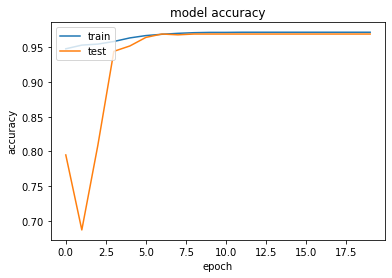

In [115]:
# summarize history for accuracy
plt.plot(history.history['binAccur'])
plt.plot(history.history['val_binAccur'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
X_val_transformed = Xscaler.transform(X_val)
y_pred = model.predict(X_val_transformed)

In [101]:
dfarray = [
    X_val.reset_index(drop = True),
    pd.DataFrame(y_pred, columns = ["probPred"]),
    pd.DataFrame(y_val).reset_index(drop = True),
    driver_val.reset_index(drop = True)]
result_Y = pd.concat(dfarray, axis=1)

In [102]:
result_Y['podiumPredicted'] = 0
predictedRaces = []
for s in result_Y["season"].unique():
    for r in result_Y["round"].unique():
        roundsel = result_Y[(result_Y["round"] == r) & (result_Y["season"] == s)]
        roundsel.sort_values('probPred', ascending = False, inplace = True)

        roundsel.reset_index(inplace = True, drop = True)
        roundsel['podiumPredicted'] = roundsel.index
        roundsel['podiumPredicted'] = roundsel["podiumPredicted"].map(lambda x: 1 if x == 0 else 0)
        predictedRaces.append(roundsel)

<ipython-input-102-65904824b378>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roundsel.sort_values('probPred', ascending = False, inplace = True)
<ipython-input-102-65904824b378>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roundsel['podiumPredicted'] = roundsel.index
<ipython-input-102-65904824b378>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [103]:
fullRacesPrediction = pd.concat(predictedRaces)
fullRacesPrediction.tail()

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age,circuit_id_BAK,circuit_id_adelaide,circuit_id_albert_park,circuit_id_americas,circuit_id_bahrain,circuit_id_catalunya,circuit_id_detroit,circuit_id_estoril,circuit_id_galvez,circuit_id_hockenheimring,circuit_id_hungaroring,circuit_id_imola,circuit_id_indianapolis,circuit_id_interlagos,circuit_id_istanbul,circuit_id_jacarepagua,circuit_id_jerez,circuit_id_kyalami,circuit_id_magny_cours,circuit_id_marina_bay,circuit_id_monaco,circuit_id_monza,circuit_id_nurburgring,circuit_id_osterreichring,circuit_id_phoenix,circuit_id_red_bull_ring,circuit_id_ricard,circuit_id_rodriguez,circuit_id_sepang,circuit_id_shanghai,circuit_id_silverstone,circuit_id_sochi,circuit_id_spa,circuit_id_suzuka,circuit_id_valencia,circuit_id_villeneuve,circuit_id_yas_marina,circuit_id_yeongam,constructor_arrows,constructor_bar,constructor_benetton,constructor_brabham,constructor_ferrari,constructor_footwork,constructor_force_india,constructor_haas,constructor_jaguar,constructor_jordan,constructor_larrousse,constructor_ligier,constructor_lotus_f1,constructor_mclaren,constructor_mercedes,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams,driver_acheson,driver_adams,driver_aitken,driver_albers,driver_albon,driver_alboreto,driver_alesi,driver_alguersuari,driver_alliot,driver_alonso,driver_ambrosio,driver_andretti,driver_angelis,driver_apicella,driver_arnoux,driver_badoer,driver_bailey,driver_baldi,driver_barbazza,driver_barilla,driver_barrichello,driver_baumgartner,driver_bellof,driver_belmondo,driver_beretta,driver_berg,driver_berger,driver_bernard,driver_bernoldi,driver_blundell,driver_bottas,driver_boullion,driver_bourdais,driver_boutsen,driver_brabham,driver_brendon_hartley,driver_brundle,driver_bruni,driver_bruno_senna,driver_buemi,driver_burti,driver_button,driver_caffi,driver_campos,driver_capelli,driver_cesaris,driver_chandhok,driver_cheever,driver_chiesa,driver_chilton,driver_comas,driver_coulthard,driver_dalmas,driver_damon_hill,driver_danner,driver_davidson,driver_deletraz,driver_diniz,driver_donnelly,driver_doornbos,driver_dumfries,driver_enge,driver_ericsson,driver_fabi,driver_fabre,driver_firman,driver_fisichella,driver_fittipaldi,driver_foitek,driver_fontana,driver_forini,driver_frentzen,driver_friesacher,driver_gachot,driver_garde,driver_gasly,driver_gene,driver_ghinzani,driver_giovinazzi,driver_glock,driver_gounon,driver_grassi,driver_grosjean,driver_grouillard,driver_gugelmin,driver_gutierrez,driver_hakkinen,driver_hamilton,driver_haryanto,driver_heidfeld,driver_herbert,driver_hesnault,driver_hulkenberg,driver_ide,driver_inoue,driver_irvine,driver_johansson,driver_jolyon_palmer,driver_jones,driver_jules_bianchi,driver_karthikeyan,driver_katayama,driver_keke_rosberg,driver_kevin_magnussen,driver_kiesa,driver_klien,driver_kobayashi,driver_kovalainen,driver_kubica,driver_kvyat,driver_laffite,driver_lagorce,driver_lammers,driver_lamy,driver_larini,driver_larrauri,driver_latifi,driver_lauda,driver_lavaggi,driver_leclerc,driver_lehto,driver_liuzzi,driver_lotterer,driver_magnussen,driver_maldonado,driver_manfred_winkelhock,driver_mansell,driver_markus_winkelhock,driver_marques,driver_martini,driver_massa,driver_matta,driver_max_verstappen,driver_mazepin,driver_mazzacane,driver_mcnish,driver_merhi,driver_michael_schumacher,driver_mick_schumacher,driver_modena,driver_montagny,driver_monteiro,driver_montermini,driver_montoya,driver_morbidelli,driver_moreno,driver_nakajima,driver_nakano,driver_nannini,driver_naspetti,driver_nasr,driver_noda,driver_norris,driver_ocon,driver_palmer,driver_panis,driver_pantano,driver_papis,driver_patrese,driver_perez,driver_petrov,driver_pic,driver_pietro_fitt

In [104]:
m = tf.keras.metrics.Accuracy()
m.update_state(fullRacesPrediction["podium"].astype(float), fullRacesPrediction["podiumPredicted"].astype(float))
print("Accuracy: ", m.result().numpy())

Accuracy:  0.9439776


In [105]:
correct = 0
wrong = 0
for s in fullRacesPrediction["season"].unique():
    for r in fullRacesPrediction["round"].unique():
        race = fullRacesPrediction[(fullRacesPrediction["round"] == r) & (fullRacesPrediction["season"] == s)]
        try:
            winningDriver = race[race["podium"] == 1].reset_index(drop=True)["driverBackup"][0]
            predictedDriver = race[race["podiumPredicted"] == 1].reset_index(drop=True)["driverBackup"][0]
        except:
            continue
            
        if winningDriver == predictedDriver:
            correct += 1
        else:
            wrong += 1
            
        print("WINNING:", winningDriver, " //  PREDICTED", predictedDriver)
        
    p = round((correct / (correct + wrong)) * 100)
    print("----- RATIO FOR SEASONS:", s, "AT", p, "%")

WINNING: hamilton  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
WINNING: hamilton  //  PREDICTED hamilton
WINNING: hamilton  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
WINNING: perez  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED max_verstappen
WINNING: max_verstappen  //  PREDICTED max_verstappen
WINNING: ocon  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
WINNING: hamilton  //  PREDICTED hamilton
WINNING: bottas  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED max_verstappen
WINNING: hamilton  //  PREDICTED hamilton
WINNING: hamilton  //  PREDICTED hamilton
WINNING: max_verstappen  //  PREDICTED hamilton
----- RATIO FOR SEASONS: 2021 AT 47 %


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 4,
      line = dict(color = "black", width = 0.5),
      label = ["Win Predicted", "Win Actual", "Loss Actual", "Loss Predicted"],
      color = "red"
    ),
    link = dict(
      source = [0, 0, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2, 1],
      value = [fullRacesPrediction["Result"].value_counts()["Win Predicted-Win Actual"],
               fullRacesPrediction["Result"].value_counts()["Win Predicted-Loss Actual"],
               fullRacesPrediction["Result"].value_counts()["Loss Predicted-Win Actual"]
              ]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [132]:
# END HERE

In [ ]:
# ---------------- DEBUG